In [89]:
# Third party
import importlib
import torch
import matplotlib.pyplot as plt

# User
import base.abstract
import base.mlp
import base.train
import base.encode
import base.pre_process
import model
import attention

importlib.reload(base.abstract)
importlib.reload(base.mlp)
importlib.reload(base.train)
importlib.reload(base.encode)
importlib.reload(base.pre_process)
importlib.reload(base.norm)
importlib.reload(model)
importlib.reload(attention)

from base.train import sgd
from base.encode import get_encoder_decoder
from base.mlp import LinearLayer, MLP
from base.train import sgd
from base.pre_process import get_dataset
from model import Attention
from attention import BatchedAttentionHead
from encode import positional_encode

In [90]:
encoder, decoder = get_encoder_decoder(training_data="../data/shakespear.txt", type='character')
# let's now encode the entire text dataset and store it into a torch.Tensor
with open("../data/shakespear.txt", 'r', encoding='utf-8') as f:
    text = f.read()
text_encoded = torch.tensor(encoder(text), dtype=torch.long)
unique_chars = sorted(list(set(text)))

In [91]:
token_length = 3
dataset =  get_dataset(text_encoded, 3, context_window="expanding")
train_data, train_targets = dataset["train"]
validation_data, validation_targets = dataset["validation"]
len(train_data), len(validation_data)

(948085, 167309)

In [102]:
hp = {
    "init_learning_rate": .1,
    "converging_learning_rate": .01,
    "epochs": 100000,
    "dim_of_embedding": 2,
    "dim_of_attention_embedding": 2,
    "num_layer_1_nodes": 10,
    "mini_batch_size": 3,
    "token_length": 3,
}

params = {
    "num_of_unique_chars": len(unique_chars),
    "positional_encoding_func": positional_encode,
    "attention_block_type": "decoder"
}

l1 = LinearLayer(
    num_of_inputs=hp['dim_of_attention_embedding'], #3x8x3 3x10 = 3x8x10
    num_of_neurons=10,
    append_pre_activation_layer=True,
    activation_func=torch.tanh,
)
l2 = LinearLayer(
    num_of_inputs=10,
    num_of_neurons=len(unique_chars),
)

mlp_model = MLP(layers=[l1,l2])
attention_model = Attention(hp, mlp_model, **params)


In [103]:
attention_model.require_grad()
loss_list = []
sgd(hp
    , attention_model
    , training_inputs=train_data
    , training_targets=train_targets
    , loss_list=loss_list
)


epoch: 0 / 400000, loss: 8.5290
epoch: 10000 / 400000, loss: 3.4277
epoch: 20000 / 400000, loss: 2.6943
epoch: 30000 / 400000, loss: 2.6758
epoch: 40000 / 400000, loss: 3.1273
epoch: 50000 / 400000, loss: 2.9559
epoch: 60000 / 400000, loss: 2.4662
epoch: 70000 / 400000, loss: 2.4653
epoch: 80000 / 400000, loss: 2.4513
epoch: 90000 / 400000, loss: 3.6024
epoch: 100000 / 400000, loss: 2.4351
epoch: 110000 / 400000, loss: 3.0269
epoch: 120000 / 400000, loss: 2.5417
epoch: 130000 / 400000, loss: 2.6953
epoch: 140000 / 400000, loss: 2.9939
epoch: 150000 / 400000, loss: 3.3061
epoch: 160000 / 400000, loss: 2.6050
epoch: 170000 / 400000, loss: 2.9127
epoch: 180000 / 400000, loss: 2.5607
epoch: 190000 / 400000, loss: 2.2540
epoch: 200000 / 400000, loss: 2.8417
epoch: 210000 / 400000, loss: 2.6318
epoch: 220000 / 400000, loss: 3.2501
epoch: 230000 / 400000, loss: 2.4245
epoch: 240000 / 400000, loss: 3.0722
epoch: 250000 / 400000, loss: 2.4913
epoch: 260000 / 400000, loss: 3.1025
epoch: 270000 /

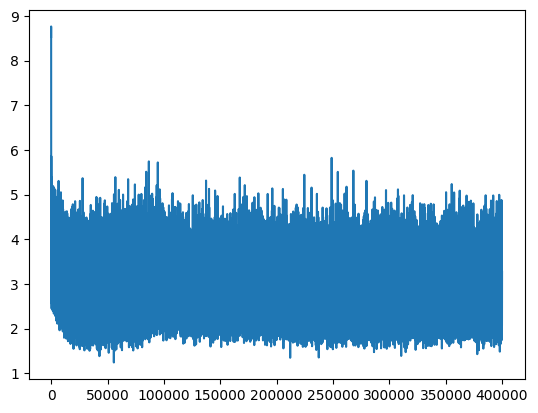

In [104]:
plt.plot(loss_list)


In [105]:
# Compute negative log likelihood of the train/validation

print(f"train loss: {attention_model.dataset_loss(train_data, train_targets)}")
print(f"validation loss: {attention_model.dataset_loss(validation_data, validation_targets)}" )

train loss: 2.8117619090825117
validation loss: 2.825815765519993


In [106]:
decoder(attention_model.generate(200))

"GDUICCimsrind s F, t teag tshy alakawe gitthid oome\nVTheasrvad oan\nAot miwy,e 's YAIMi e  te  ld lf et  INwyeeadrs t b s tuorl.ot, ibove\nS tgce e sasainun y be \nIs.Fau danovdomouhers,\nz owaeb rila:pha"